In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import os
from os.path import dirname, join as pjoin
import scipy.io as sio
from networkx.algorithms import community 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GraphMeasures:
    def __init__(self,threshold):
        self.threshold = threshold
        self.avg_node_connect = None
        self.adj_mat = None
        return
    
    def get_eigenvector_centrality(self,G):
        return networkx.eigenvector_centrality(G)
    
    def get_betweenness_centrality (self, G):
        return networkx.betweenness_centrality(G)
        
    def get_node_avg (self, G):
        return networkx.average_node_connectivity(G)
    
    def get_comm_central(self, G):
        return (networkx.community.girvan_newman(G))
                
    def get_adj_threshold(self, adj_mat):
        
        adj_mat[adj_mat <= self.threshold] = 0
        adj_mat[adj_mat > self.threshold] = 1
        return adj_mat
        
    def get_graphs(self, g_type, xp_num,fmri = False):
        base_name = "correlation/fmri/" if fmri else "correlation/"
        graph_list = []
        user = "sub-xp"
        for i in range(1,23):
            file = base_name+user+str(xp_num)+"0"+str(i)+"\\" + g_type + ".mat"
            try:
                mat_contents = sio.loadmat(file)
                adj_mat = np.array(mat_contents["rho"])
                adj_mat = self.get_adj_threshold(adj_mat)

                G = nx.convert_matrix.from_numpy_matrix(adj_mat)
                graph_list.append(G) 
            except FileNotFoundError: 
                continue
        return graph_list
    
    def get_subj_graphs(self, sub, run):
        base_names = ["correlation/fmri/sub-xp", "correlation/sub-xp"]
        graph_list = []

        files = [base_name+sub+"/" + run + ".mat" for base_name in base_names]
        for file in files:
            try:
                mat_contents = sio.loadmat(file)
                adj_mat = np.array(mat_contents["rho"])
                adj_mat = self.get_adj_threshold(adj_mat)

                G = nx.convert_matrix.from_numpy_matrix(adj_mat)
                graph_list.append(G) 
            except FileNotFoundError: 
                continue
        return graph_list

In [84]:
class GraphPlots:
    def __init__(self):
        return 
    def get_between_graph(self,graph_list, g):
        t = g.get_betweenness_centrality(graph_list[0])
        for graph in graph_list: 
            
            d = g.get_betweenness_centrality(graph)

            plt.bar(d.keys(), d.values(), color='g')
       
            plt.show()
            return 
   

    def get_deg_v_connectivity(self,graph_list, name):
        for graph in graph_list:
            
            val = nx.average_degree_connectivity(graph)
            x = val.keys()
            y = val.values()
            
            plt.scatter(x,y, color = 'g')
            plt.xlabel("degree")
            plt.ylabel("avg connectivity")
            plt.title("degree versus k-avg connectivity of "+name)
            plt.savefig("degree_v_connectivity_xp1_"+name+".png")
            plt.show()
            
    def get_avg_path(self, graph_list, t): 
        path_len = []
        for graph in graph_list: 
            for C in (graph.subgraph(c).copy() for c in nx.connected_components(graph)):
                x = nx.average_shortest_path_length(C)
                #if( x != 0): 
                path_len.append(x)
                
        return np.mean(path_len)


    def get_similarity(self,graph_list):
        central = []
        
        for graph in graph_list:
            pr = nx.pagerank(graph)
            ranked = [[key, pr[key]] for key in pr.keys()]
            sorted_ranked = sorted(ranked, key=lambda item: item[1])

            # this makes ranked work. No idea why. Seems really strange.
            sorted_ranked = [sorted_ranked[i].append(i) for i in range(len(sorted_ranked))]
            
            central.append(ranked)
        
        matrix = np.zeros((len(central),len(central)))
        for i in range(len(central)):
            for j in range(i, len(central)):
                matrix[i,j] = sum([abs(central[i][x][2]-central[j][x][2]) for x in range(len(central[i]))])
                matrix[j,i] = matrix[i,j]
        
        return matrix
    
    
    def get_node_avg(self,graph_list, g, file_name):
        avg_con = []
        for graph in graph_list: 
            d = g.get_node_avg(graph)
            avg_con.append(d)

        plt.hist(avg_con, color='g')
        plt.savefig(file_name)
        plt.show()
        return 

    def avg_path_len_bar(self,src1, src2, title,graph_types):
    
        
        blue_bar = src1
        orange_bar = src2
        ind = np.arange(max(len(src1), len(src2)))
        plt.figure(figsize=(10,5))
        width = 0.3       
        plt.bar(ind,src1 , width, label='Fmri ')
        plt.bar(ind + width, src2, width, label='EEG')

        plt.xlabel('Graph Type')
        plt.ylabel('Average path length')
        plt.title('Average path length' + title)
        plt.xticks(ind + width / 2, graph_types)
        plt.legend(loc='best')
        plt.show()
    
    def graph_avg_and_var(self,graph_list, t, xp_num, fmri = False):
       
        file_name = "xp"+str(xp_num)+"_" + t
        
        graph_degree_list = []
        for graph in graph_list:
            graph_degree_list.append(list(dict(graph.degree).values()))

        avg_list = np.mean(graph_degree_list,axis = 0)
        varinance_list = np.std(graph_degree_list,axis = 0)
        

        n = 63
        
        plt.bar(np.arange(0, n),np.array(avg_list), color='blue', align='center', alpha = 0.5, label = "avg")
        plt.bar( np.arange(0, n),np.array(varinance_list) , color='red', align='center',alpha = 0.5, label = "St.Dev")
#         plt.tight_layout()
        plt.title("average and varience of "+ file_name)
        plt.xlabel("node number")
        plt.ylabel("measure ")
        plt.legend()
        measure = 'fmri' if fmri else 'eeg'
        
        try:
            plt.savefig("data/pictures/" + measure +"/var_avg_"+file_name+".png",dpi= 1000)
        except:
            os.makedirs("data/pictures/" + measure + "/")
            plt.savefig("data/pictures/" + measure +"/var_avg_"+file_name+".png",dpi= 1000)

        
        

        plt.show()
    


 

In [79]:
def similarity():
    g = GraphMeasures(0.75)
    subs = ["101","102","103","104","105","106","107","108","109","110","201","202","203","204","205","206","207","210","211","213","216","217","218","219","220","221","222"]
    runs = ["eegNF","fmriNF" ,"eegfmriNF","motorloc", "MIpost", "MIpre","1dNF_run-01","1dNF_run-02","1dNF_run-03","1dNF_run-04","MIpost","MIpre","2dNF_run-01","2dNF_run-02","2dNF_run-03"]
    matrix = np.zeros((len(subs),len(runs)))

    g_plots = GraphPlots()
    
    for i in range(len(subs)):
        for j in range(len(runs)):
            print(subs[i],runs[j])

            graph_list = g.get_subj_graphs(subs[i],runs[j])
            if len(graph_list) < 2: 
                   matrix[i,j] = None
                   continue
#             breakpoint()
            matrix[i,j] = g_plots.get_similarity(graph_list)[0,1]

    
    return matrix

mat = similarity()


101 eegNF
101 fmriNF
101 eegfmriNF
101 motorloc
101 MIpost
101 MIpre
101 1dNF_run-01
101 1dNF_run-02
101 1dNF_run-03
101 1dNF_run-04
101 MIpost
101 MIpre
101 2dNF_run-01
101 2dNF_run-02
101 2dNF_run-03
102 eegNF
102 fmriNF
102 eegfmriNF
102 motorloc
102 MIpost
102 MIpre
102 1dNF_run-01
102 1dNF_run-02
102 1dNF_run-03
102 1dNF_run-04
102 MIpost
102 MIpre
102 2dNF_run-01
102 2dNF_run-02
102 2dNF_run-03
103 eegNF
103 fmriNF
103 eegfmriNF
103 motorloc
103 MIpost
103 MIpre
103 1dNF_run-01
103 1dNF_run-02
103 1dNF_run-03
103 1dNF_run-04
103 MIpost
103 MIpre
103 2dNF_run-01
103 2dNF_run-02
103 2dNF_run-03
104 eegNF
104 fmriNF
104 eegfmriNF
104 motorloc
104 MIpost
104 MIpre
104 1dNF_run-01
104 1dNF_run-02
104 1dNF_run-03
104 1dNF_run-04
104 MIpost
104 MIpre
104 2dNF_run-01
104 2dNF_run-02
104 2dNF_run-03
105 eegNF
105 fmriNF
105 eegfmriNF
105 motorloc
105 MIpost
105 MIpre
105 1dNF_run-01
105 1dNF_run-02
105 1dNF_run-03
105 1dNF_run-04
105 MIpost
105 MIpre
105 2dNF_run-01
105 2dNF_run-02
105 2d

In [80]:
def get_avg_path_plt(src1, src2): 
    
    plt.bar(np.arange(0, len(src1)),np.array(src1), color='blue', align='center', alpha = 0.5, label = "fmri")
    plt.bar( np.arange(0, len(src2)),np.array(src2) , color='red', align='center',alpha = 0.5, label = "eeg")
    plt.tight_layout()
    plt.xlabel("node number")
    plt.ylabel("measure ")

In [81]:
def main():
    g_plots = GraphPlots()
    eeg_1_path, eeg_2_path, fmri_1_path, fmri_2_path = [],[],[],[]
    # EEG XP1
    graph_t_xp1 = ["eegNF","fmriNF" ,"eegfmriNF","motorloc", "MIpost", "MIpre"]
    node_avg =[]
    for t in graph_t_xp1: 
        g = GraphMeasures(0.75)
        #breakpoint()
        graph_list = g.get_graphs(t,1)
        #breakpoint()
        g_plots.graph_avg_and_var(graph_list, t, 1)
        eeg_1_path.append(g_plots.get_avg_path(graph_list, t))



    # EEG XP2
    graph_t_xp2 = ["1dNF_run-01","1dNF_run-02","1dNF_run-03","1dNF_run-04","MIpost","MIpre","2dNF_run-01","2dNF_run-02","2dNF_run-03"]
    for t in graph_t_xp2: 
        g = GraphMeasures(0.75)
        graph_list = g.get_graphs(t,2)
        g_plots.graph_avg_and_var(graph_list, t, 2)
        eeg_2_path.append(g_plots.get_avg_path(graph_list, t))


    #FMRI XP1
    for t in graph_t_xp1: 
        print(t, "FMRI XP 1")
        g = GraphMeasures(0.75)
        graph_list = g.get_graphs(t,1,fmri = True)
        g_plots.graph_avg_and_var(graph_list, t, 1, fmri=True)
        fmri_1_path.append(g_plots.get_avg_path(graph_list, t))


    #FMRI XP2
    for t in graph_t_xp2: 
        print(t, "FMRI XP 1")
        g = GraphMeasures(0.75)
        graph_list = g.get_graphs(t,2,fmri = True)
        g_plots.graph_avg_and_var(graph_list, t, 2, fmri=True)
        fmri_2_path.append(g_plots.get_avg_path(graph_list, t))

    g_plots.avg_path_len_bar(fmri_1_path, eeg_1_path, "XP1", graph_t_xp1)
    
    g_plots.avg_path_len_bar(fmri_2_path, eeg_2_path,"XP2",graph_t_xp2)

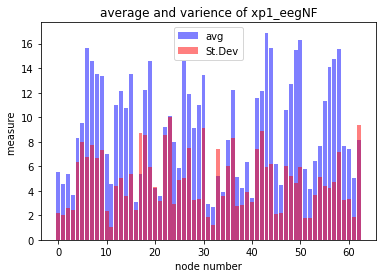

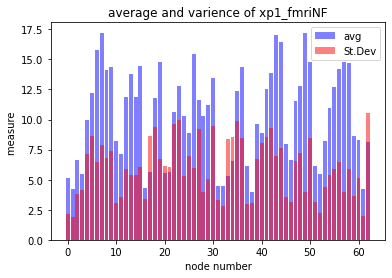

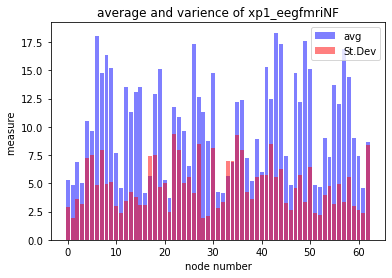

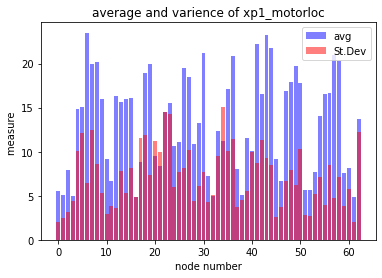

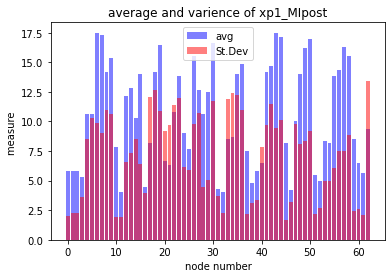

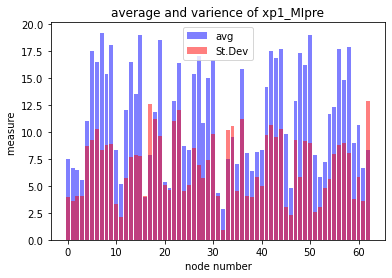

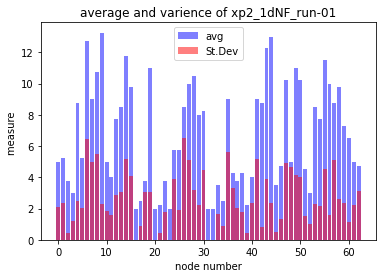

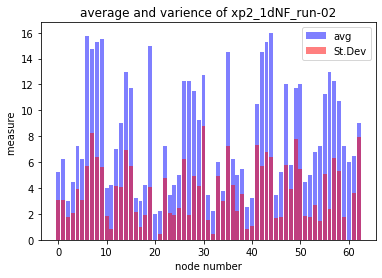

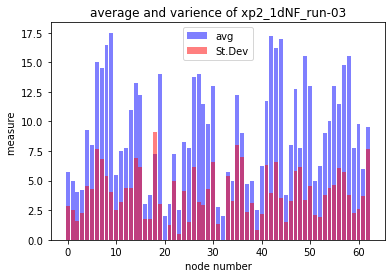

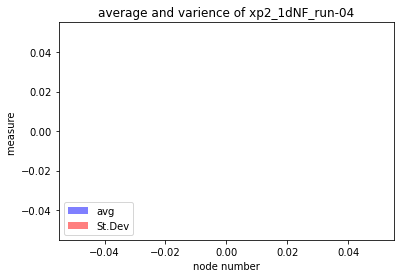

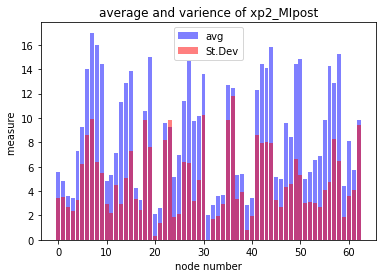

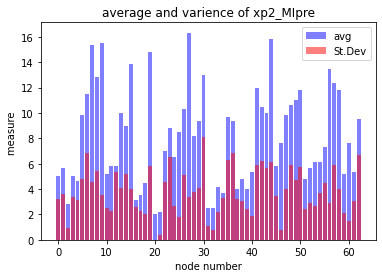

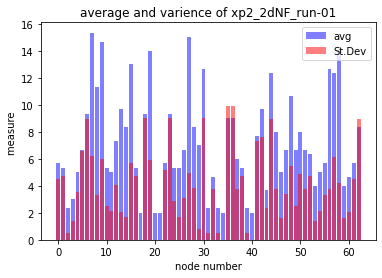

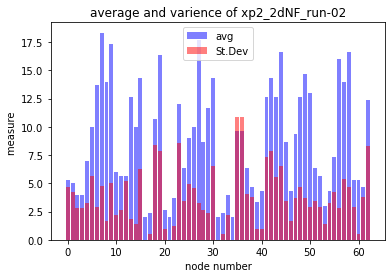

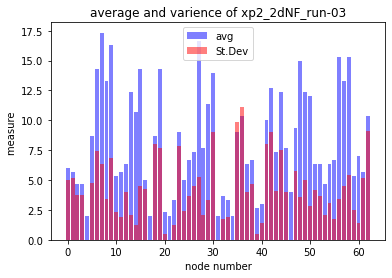

eegNF FMRI XP 1


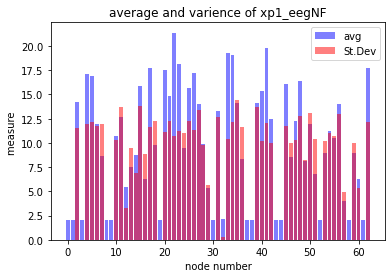

fmriNF FMRI XP 1


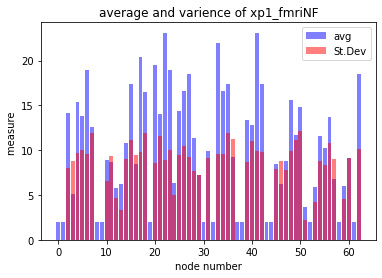

eegfmriNF FMRI XP 1


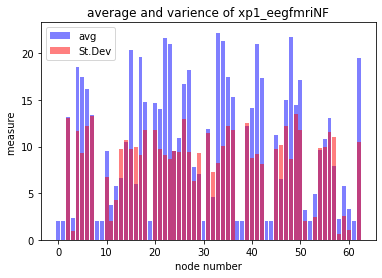

motorloc FMRI XP 1


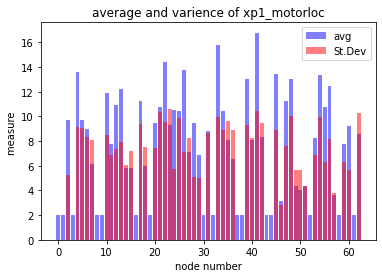

MIpost FMRI XP 1


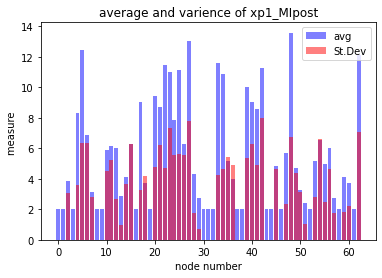

MIpre FMRI XP 1


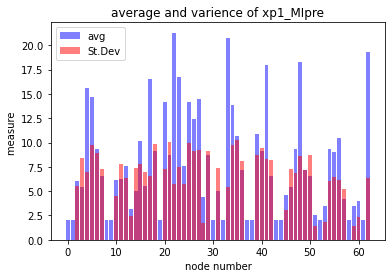

1dNF_run-01 FMRI XP 1


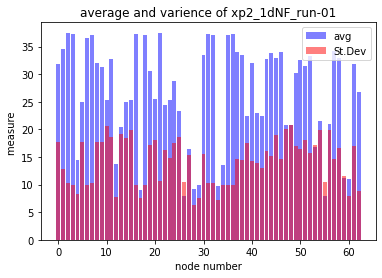

1dNF_run-02 FMRI XP 1


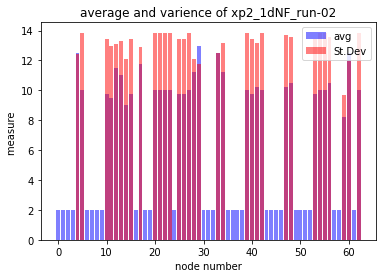

1dNF_run-03 FMRI XP 1


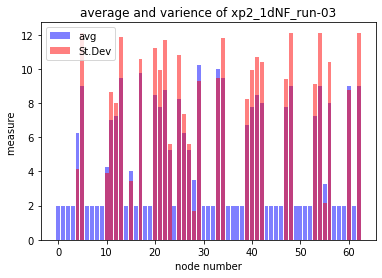

1dNF_run-04 FMRI XP 1


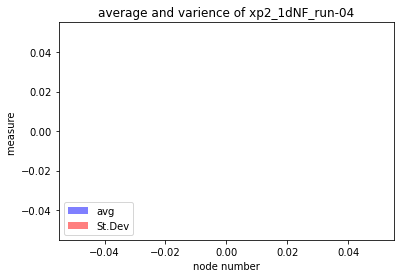

MIpost FMRI XP 1


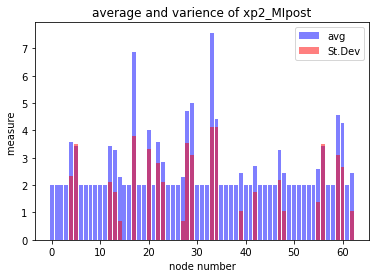

MIpre FMRI XP 1


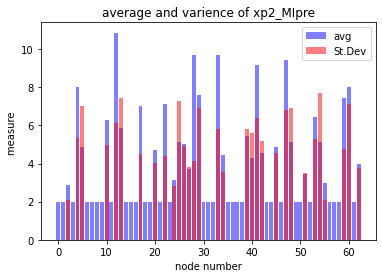

2dNF_run-01 FMRI XP 1


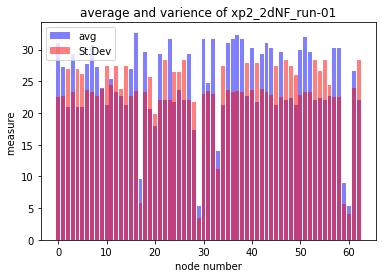

2dNF_run-02 FMRI XP 1


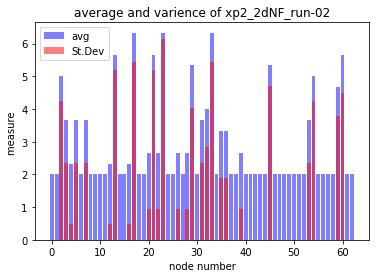

2dNF_run-03 FMRI XP 1


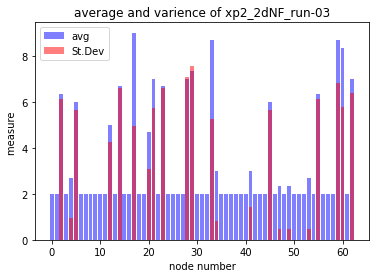

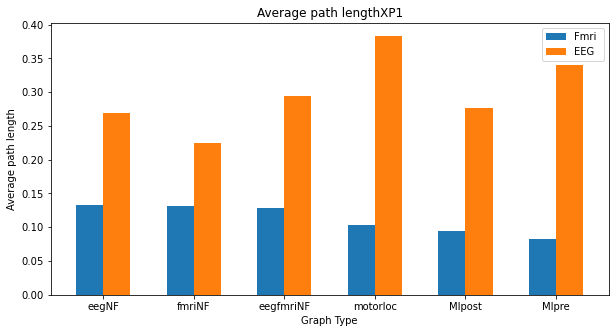

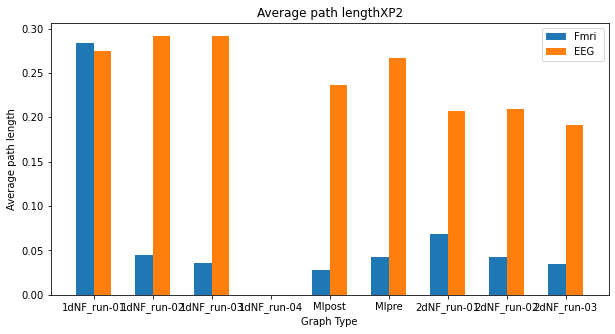

In [85]:
main()

In [42]:
g_plots = GraphPlots()


# print(mat)

print(np.nanmean(mat), np.nanstd(mat))

val = []
for i in range(181):
    graph_list = [nx.generators.random_graphs.fast_gnp_random_graph(63,.1),nx.generators.random_graphs.fast_gnp_random_graph(63,.1)]
    val.append( g_plots.get_similarity(graph_list)[0,1])

print(np.nanmean(val), np.nanstd(val))


print("So, based on centrality of all nodes, the fmri and eeg graphs for the same person on the same run are no different than that of a random graph")


1280.1878453038673 127.02245882375891
1310.9060773480662 100.50071887032739
So, based on centrality of all nodes, the fmri and eeg graphs for the same person on the same run are no different than that of a random graph


181

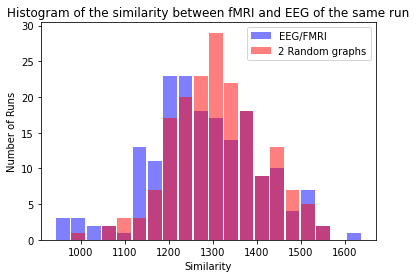

In [72]:
mat
sim_list = []

for row in mat:
    for item in row:
#         breakpoint()
        if not np.isnan(item):

            sim_list.append(item)
            
sim_list
_, bins, _ = plt.hist(sim_list, 20, color='blue', alpha = .5, rwidth = .9, label = "EEG/FMRI")
plt.hist(val, bins, color='red', alpha = .5, rwidth = .9, label = "2 Random graphs")
plt.legend()
plt.title("Histogram of the similarity between fMRI and EEG of the same run")
plt.xlabel("Similarity")
plt.ylabel("Number of Runs")
plt.savefig("data/pictures/sim_distro.png",dpi= 1000)
len(sim_list)

In [8]:
graph_list = []
g = GraphMeasures(0.75)

subs = ["101","102","103","104","105","106","107","108","109","110","201","202","203","204","205","206","207","210","211","213","216","217","218","219","220","221","222"]
runs = ["eegNF","fmriNF" ,"eegfmriNF","motorloc", "MIpost", "MIpre","1dNF_run-01","1dNF_run-02","1dNF_run-03","1dNF_run-04","MIpost","MIpre","2dNF_run-01","2dNF_run-02","2dNF_run-03"]
matrix = np.zeros((len(subs),len(runs)))

g_plots = GraphPlots()

for i in range(len(subs)):
    for j in range(len(runs)):
#         print(subs[i],runs[j])
#         breakpoint()

        graphs = g.get_subj_graphs(subs[i],runs[j])
    
        if len(graphs) < 2: 
                       matrix[i,j] = None
                       continue
#         breakpoint()
        eeg_graph,fmri_graph = graphs
        graph_list.append([eeg_graph, subs[i], runs[j], "eeg"])
        graph_list.append([fmri_graph, subs[i], runs[j], "fmri"])
    
    
num_edges = []    
for graph in graph_list:
#     breakpoint()
    num_edges.append([len(graph[0].edges), graph[1], graph[2], graph[3]])
    
    

In [9]:
num_edges.sort()
num_edges

[[63, '205', '2dNF_run-02', 'eeg'],
 [63, '205', 'MIpost', 'eeg'],
 [63, '205', 'MIpost', 'eeg'],
 [64, '203', '1dNF_run-03', 'eeg'],
 [65, '206', 'MIpost', 'eeg'],
 [65, '206', 'MIpost', 'eeg'],
 [65, '216', '2dNF_run-02', 'eeg'],
 [66, '216', '2dNF_run-03', 'eeg'],
 [67, '203', 'MIpost', 'eeg'],
 [67, '203', 'MIpost', 'eeg'],
 [67, '204', '2dNF_run-02', 'eeg'],
 [67, '205', '2dNF_run-03', 'eeg'],
 [67, '210', '2dNF_run-03', 'eeg'],
 [67, '216', 'MIpost', 'eeg'],
 [67, '216', 'MIpost', 'eeg'],
 [67, '222', 'MIpost', 'eeg'],
 [67, '222', 'MIpost', 'eeg'],
 [68, '210', '2dNF_run-02', 'eeg'],
 [69, '206', '1dNF_run-02', 'eeg'],
 [69, '206', '1dNF_run-03', 'eeg'],
 [71, '204', 'MIpre', 'eeg'],
 [71, '204', 'MIpre', 'eeg'],
 [72, '210', 'MIpost', 'eeg'],
 [72, '210', 'MIpost', 'eeg'],
 [72, '218', 'MIpost', 'eeg'],
 [72, '218', 'MIpost', 'eeg'],
 [73, '222', 'MIpre', 'eeg'],
 [73, '222', 'MIpre', 'eeg'],
 [74, '222', '1dNF_run-01', 'eeg'],
 [75, '203', 'MIpre', 'eeg'],
 [75, '203', 'MIpre'

In [64]:
edge_dist_eeg = [x[0] for x in num_edges if x[3] == 'eeg']
edge_dist_fmri = [x[0] for x in num_edges if x[3] == 'fmri']
for edge in num_edges:
    if edge[1] == '204' and edge[2] == '2dNF_run-01':
        print(edge)

[180, '204', '2dNF_run-01', 'fmri']
[1739, '204', '2dNF_run-01', 'eeg']


In [24]:
62*61/2

1891.0

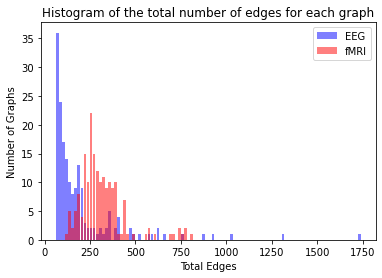

In [74]:
edge_dist_eeg
edge_dist_fmri
_, bins, _ = plt.hist(edge_dist_eeg, 100, color='blue', alpha = .5, rwidth = .9, label = "EEG")
plt.hist(edge_dist_fmri, bins, color='red', alpha = .5, rwidth = .9, label = "fMRI")
plt.legend()
plt.title("Histogram of the total number of edges for each graph")
plt.xlabel("Total Edges")
plt.ylabel("Number of Graphs")
plt.savefig("data/pictures/edge_distro.png",dpi= 1000)

In [11]:
graph_t, i =["eegNF","fmriNF" ,"eegfmriNF"], 0
for j in graph_t: 
    i+=1
    g = graph_measures(0.75)
    graph_list = g.get_graphs(graph_t.index(j))
    
    avg_node = get_eigenvector_centrality(graph_list, g, (j+str(i)))



NameError: name 'graph_measures' is not defined